In [46]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
import os
import copy
from pandas.core.common import flatten
import glob
import shutil
import cv2

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.transforms import v2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from pandas.core.common import flatten
import copy
import numpy as np
import random

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import glob
from tqdm import tqdm

In [47]:
os.chdir(os.getcwd())
os.listdir()

['.git', 'data', 'model_weights.pth', 'README.md', 'test.ipynb']

In [62]:
df = pd.DataFrame(columns=["Label", "Image"])
label = df["Label"].tolist()
image = df["Image"].tolist()

for folder in os.listdir('./data'):
    if not os.path.isfile('./data/' + folder):
        for img in os.listdir('./data/' + folder):
            image_path = os.getcwd() + '/data/' + folder + "/" + img
            label.append(folder)
            image.append(image_path)

df["Label"] = label
df["Image"] = image

In [63]:
df

,Label,Image
0,ankylosaurus,d:\AI\DataHack/data/ankylosaurus/1.png
1,ankylosaurus,d:\AI\DataHack/data/ankylosaurus/10.png
2,ankylosaurus,d:\AI\DataHack/data/ankylosaurus/11.png
3,ankylosaurus,d:\AI\DataHack/data/ankylosaurus/12.png
4,ankylosaurus,d:\AI\DataHack/data/ankylosaurus/13.png
...,...,...
195,triceratops,d:\AI\DataHack/data/triceratops/5.png
196,triceratops,d:\AI\DataHack/data/triceratops/6.png
197,triceratops,d:\AI\DataHack/data/triceratops/7.png
198,triceratops,d:\AI\DataHack/data/triceratops/8.png


In [64]:
data = df.to_dict(orient='records')
data_dict = {}
for diction in data:
    if(diction["Label"] not in data_dict):
        data_dict[diction['Label']] = [diction['Image']]
    else:
        data_dict[diction['Label']].append(diction['Image'])

In [65]:
train_dict = copy.deepcopy(data_dict)
for key in train_dict:
    train_dict[key] = []
validation_dict = copy.deepcopy(train_dict)
test_dict = copy.deepcopy(train_dict)

for dino in data_dict:
    train_size = int(len(data_dict[dino]) * 0.75)
    validation_size = int((len(data_dict[dino]) - train_size) / 2)
    train_data = random.sample(data_dict[dino], train_size)

    remaining = [i for i in data_dict[dino] if i not in train_data]
    validation_data = random.sample(remaining, validation_size)
    test_data = [i for i in remaining if i not in validation_data]

    train_dict[dino] = train_data
    validation_dict[dino] = validation_data
    test_dict[dino] = test_data

In [66]:
os.makedirs("./train", exist_ok=True)
os.makedirs("./val", exist_ok=True)
os.makedirs("./test", exist_ok=True)

In [67]:
for cls in train_dict:
    os.makedirs(f"./train/{cls}", exist_ok=True)
    os.makedirs(f"./val/{cls}", exist_ok=True)
    os.makedirs(f"./test/{cls}", exist_ok=True)

In [68]:
for cls in train_dict:
    for img in train_dict[cls]:
        shutil.copy2(img, f"./train/{cls}/{os.path.basename(img)}")
    for img in validation_dict[cls]:
        shutil.copy2(img, f"./val/{cls}/{os.path.basename(img)}")
    for img in test_dict[cls]:
        shutil.copy2(img, f"./test/{cls}/{os.path.basename(img)}")

d:\AI\DataHack/data/ankylosaurus/2.png
d:\AI\DataHack/data/ankylosaurus/25.png
d:\AI\DataHack/data/ankylosaurus/40.png
d:\AI\DataHack/data/ankylosaurus/4.png
d:\AI\DataHack/data/ankylosaurus/28.png
d:\AI\DataHack/data/ankylosaurus/38.png
d:\AI\DataHack/data/ankylosaurus/34.png
d:\AI\DataHack/data/ankylosaurus/9.png
d:\AI\DataHack/data/ankylosaurus/8.png
d:\AI\DataHack/data/ankylosaurus/35.png
d:\AI\DataHack/data/ankylosaurus/29.png
d:\AI\DataHack/data/ankylosaurus/30.png
d:\AI\DataHack/data/ankylosaurus/6.png
d:\AI\DataHack/data/ankylosaurus/16.png
d:\AI\DataHack/data/ankylosaurus/10.png
d:\AI\DataHack/data/ankylosaurus/33.png
d:\AI\DataHack/data/ankylosaurus/22.png
d:\AI\DataHack/data/ankylosaurus/26.png
d:\AI\DataHack/data/ankylosaurus/31.png
d:\AI\DataHack/data/ankylosaurus/15.png
d:\AI\DataHack/data/ankylosaurus/24.png
d:\AI\DataHack/data/ankylosaurus/14.png
d:\AI\DataHack/data/ankylosaurus/39.png
d:\AI\DataHack/data/ankylosaurus/3.png
d:\AI\DataHack/data/ankylosaurus/5.png
d:\AI\D

In [89]:
train_data_path = './train'
val_data_path = './val' 
test_data_path = './test'

train_image_paths = [] #to store image paths in list
classes = [] #to store class values

In [90]:
# 1.Train
for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('\\')[-1]) 
    train_image_paths.append(glob.glob(data_path + '/*'))
    
train_image_paths = list(flatten(train_image_paths))
random.shuffle(train_image_paths)

# 2.Val
val_image_paths = []
for data_path in glob.glob(val_data_path + '/*'):
    val_image_paths.append(glob.glob(data_path + '/*'))

val_image_paths = list(flatten(val_image_paths))
random.shuffle(val_image_paths)

# 3.Test
# create the test_image_paths
test_image_paths = []
for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(glob.glob(data_path + '/*'))

test_image_paths = list(flatten(test_image_paths))
random.shuffle(test_image_paths)

print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(val_image_paths), len(test_image_paths)))

Train size: 150
Valid size: 25
Test size: 25


In [91]:
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

In [92]:
idx_to_class

{0: 'ankylosaurus',
 1: 'brontosaurus',
 2: 'pterodactyl',
 3: 'trex',
 4: 'triceratops'}

In [93]:
transform_train = v2.Compose([
    v2.Resize((224, 224)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomRotation(30),
    v2.RandomAffine(30),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_test = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [110]:
class DinoDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = torch.from_numpy(image)

        label = image_filepath.split('\\')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = image.permute(2, 0, 1)
            image = self.transform(image)

        return image, label

train_dataset = DinoDataset(train_image_paths, transform_train)
val_dataset = DinoDataset(val_image_paths, transform_test)
test_dataset = DinoDataset(test_image_paths, transform_test)

In [111]:
print('The shape of tensor for 50th image in train dataset: ', val_dataset[10][0].shape)
print('The label for 50th image in train dataset: ', val_dataset[10][1])

The shape of tensor for 50th image in train dataset:  torch.Size([3, 224, 224])
The label for 50th image in train dataset:  4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

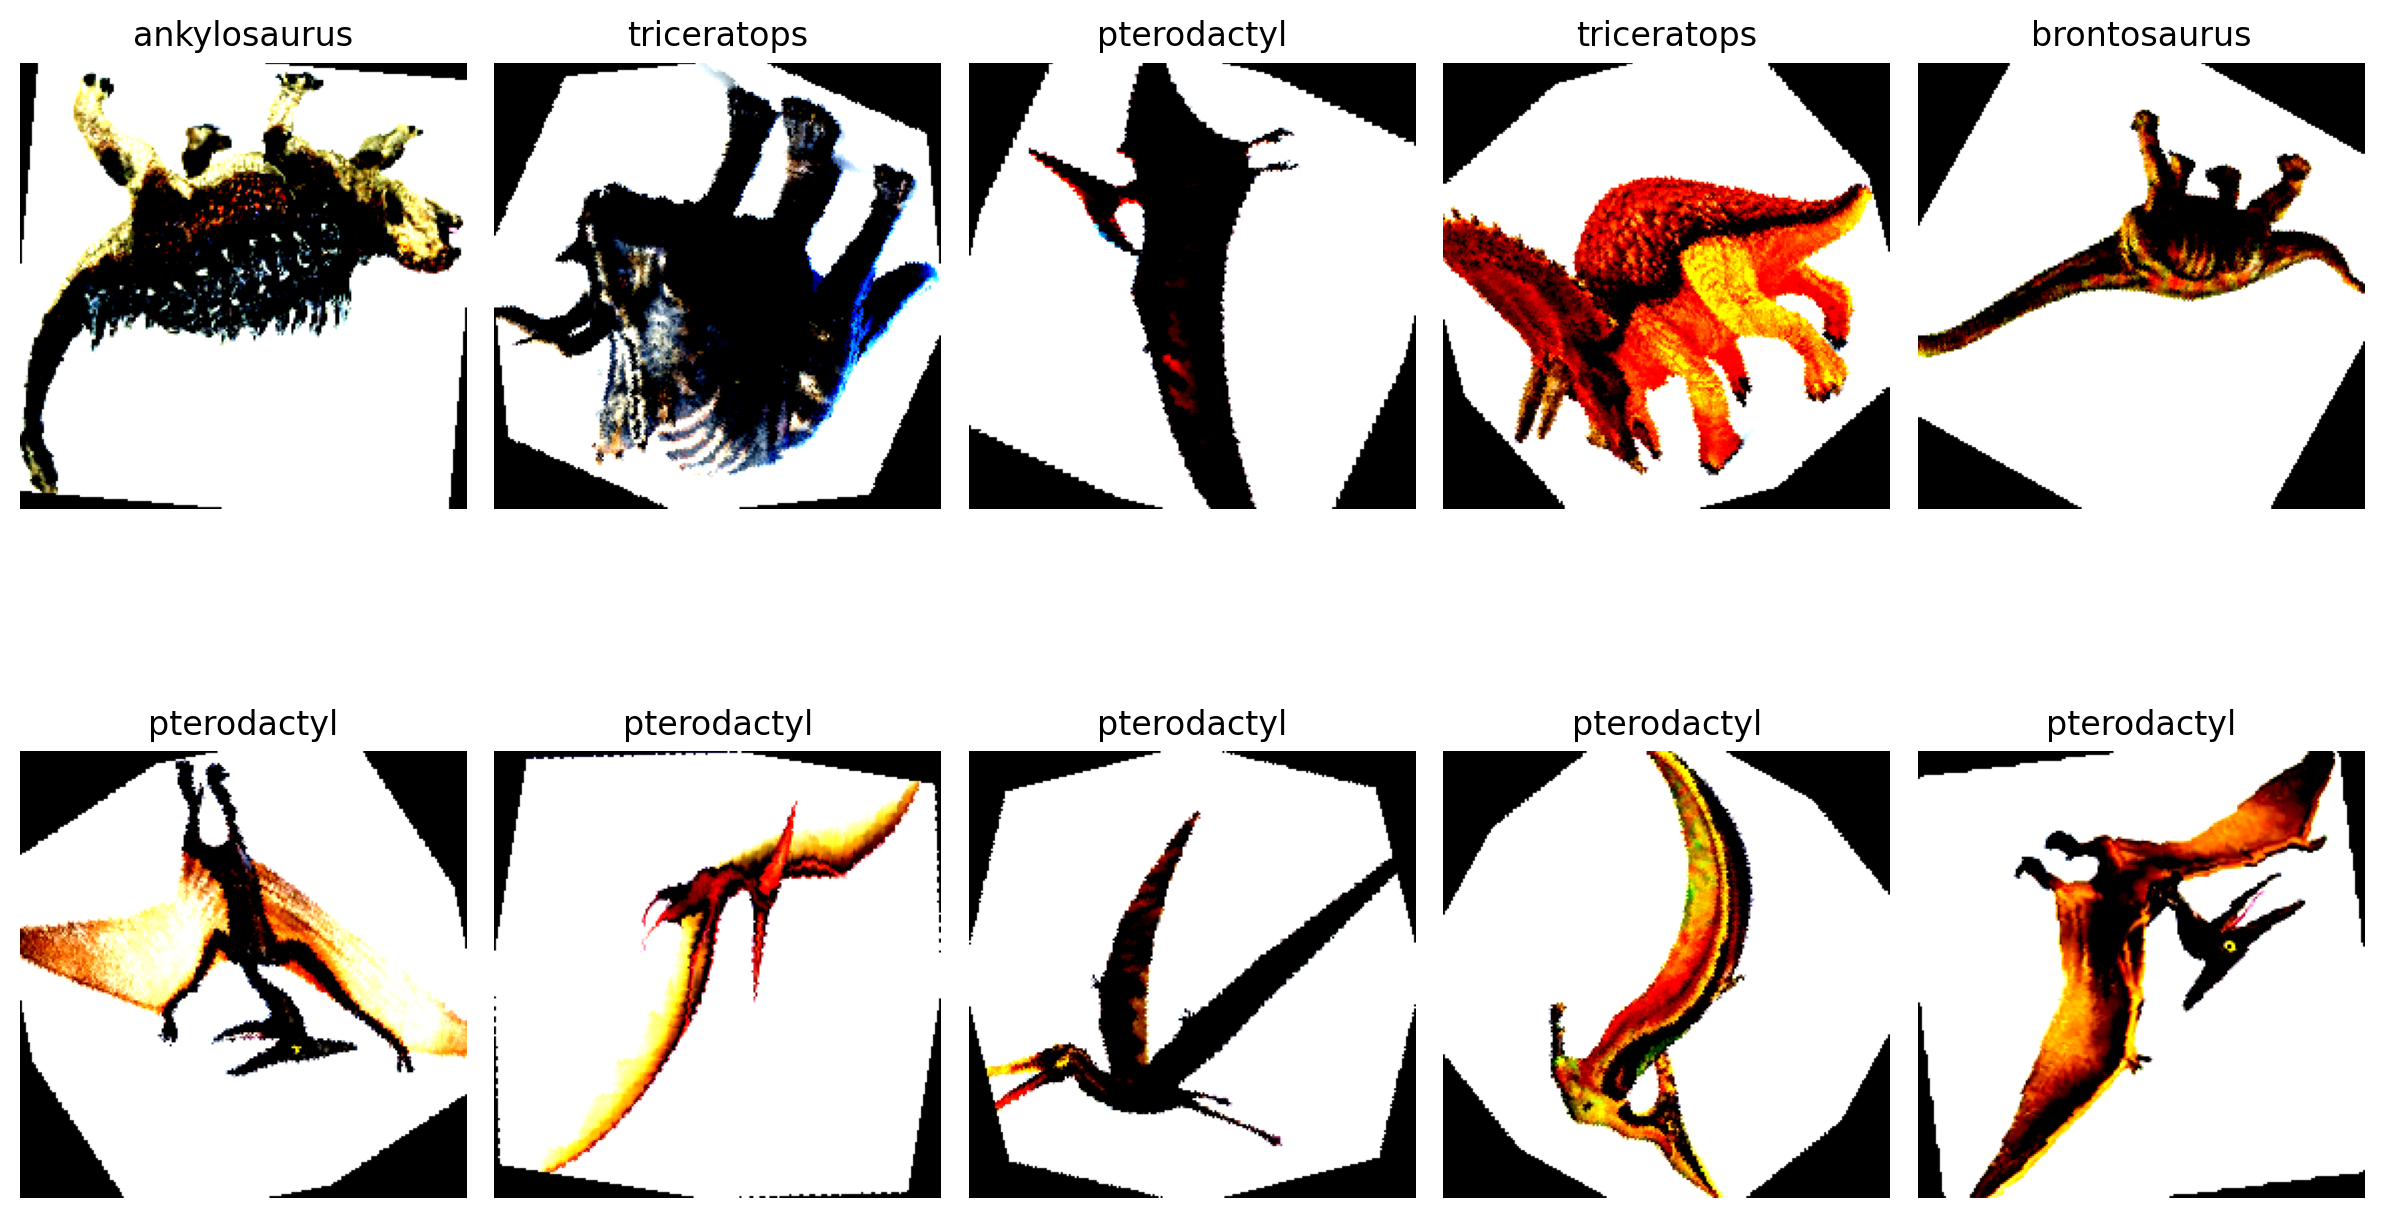

In [112]:
import matplotlib.pyplot as plt

def visualize_augmentations(dataset, idx=0, samples=10, cols=5, random_img = False):
    
    dataset = copy.deepcopy(dataset)
    #we remove the normalize and tensor conversion from our augmentation pipeline
    # transformss = [t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))]
    # dataset.transform = A.Compose(transformss)
    rows = samples // cols
    
        
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1,len(train_image_paths))
        image, lab = dataset[idx]
        image = image.permute(1, 2, 0)
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(idx_to_class[lab])
    plt.tight_layout(pad=1)
    plt.show()    

visualize_augmentations(train_dataset,np.random.randint(1,len(train_image_paths)), random_img = True)


In [113]:
train_loader = DataLoader(
    train_dataset, batch_size=128, shuffle=True
)

val_loader = DataLoader(
    val_dataset, batch_size=128, shuffle=True
)

test_loader = DataLoader(
    test_dataset, batch_size=128, shuffle=False
)

In [114]:
# Check for GPU and CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("No GPU available, using the CPU instead.")

Using GPU: NVIDIA GeForce RTX 4090 Laptop GPU


In [115]:
model = models.efficientnet_b0(pretrained=True)
num_classes = 5  # replace with your number of classes
model.classifier = torch.nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

c:\Users\24510\miniconda3\envs\Bert\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\24510\miniconda3\envs\Bert\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [116]:
num_epochs = 100000
patience = 5 
best_loss = float('inf')
early_stopping_counter = 0

for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print loss every epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    model.eval()
    with torch.no_grad():
        validation_loss = 0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
        validation_loss /= len(val_loader)

    # Early stopping logic
    if validation_loss < best_loss:
        best_loss = validation_loss
        early_stopping_counter = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        early_stopping_counter += 1
        print(f"EarlyStopping counter: {early_stopping_counter} out of {patience}")

    if early_stopping_counter >= patience:
        print("Early stopping")
        break

Epoch [1/100000], Loss: 1.2615
Epoch [2/100000], Loss: 0.7686
Epoch [3/100000], Loss: 0.2541
Epoch [4/100000], Loss: 0.0718
Epoch [5/100000], Loss: 0.0757
Epoch [6/100000], Loss: 0.0052
Epoch [7/100000], Loss: 0.0224
Epoch [8/100000], Loss: 0.2280
EarlyStopping counter: 1 out of 5
Epoch [9/100000], Loss: 0.0174
EarlyStopping counter: 2 out of 5
Epoch [10/100000], Loss: 0.0313
EarlyStopping counter: 3 out of 5
